# Feature extraction from sky images for solar 

To extract features from sky images a three step apporach was implemented. 





Average value within the disk: 86.66893586528126


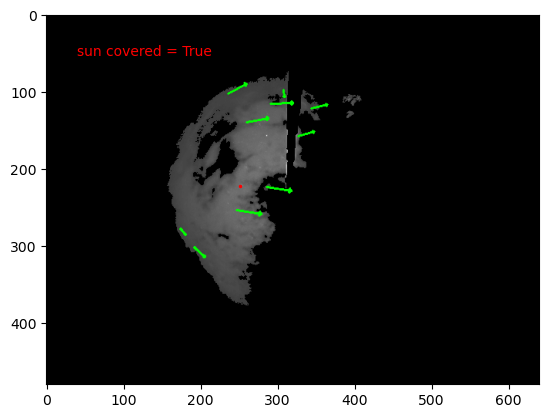

In [1]:
import numpy as np
from numpy import asarray
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage import measure, color, segmentation
from skimage.measure import label, regionprops
import blend_modes
import pandas as pd
import pvlib
import cv2
import time
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def solar_pos(filepath):
    
    tz = 'America/Bogota'
    lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
    # altitude = 50

    #Ubicación Geográfica
    # location = pvlib.location.Location(lat, lon, tz, altitude)
    times = pd.date_range('2023-01-01 00:00:00', '2024-12-31', closed='left',
                          freq='H', tz=tz)
    solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
    # remove nighttime
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    YY = filepath[-18:-14]
    MM = filepath[-14:-12]
    DD = filepath[-12:-10]
    day = YY+'-'+MM+'-'+DD
    # draw individual days
    for date in pd.to_datetime([day]):
        times = pd.date_range(date, date+pd.Timedelta('24h'), freq='30s', tz=tz)
        solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
        solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
        azimuth_radians = np.radians(solpos.azimuth)
        
    # Convert polar coordinates to Cartesian coordinates
    x_direct = solpos.apparent_zenith * np.sin(azimuth_radians)
    y_direct = solpos.apparent_zenith * np.cos(azimuth_radians)

    # Adjust Cartesian coordinates for a (480,640) image
    x = -(x_direct)*2.84+312
    k=0.0086 
    x0=312
    a=85
    L=463
    x_mapped = L / (1 + np.exp(-k * (x - x0))) + a
    o = 6.4
    y_mapped =  y_direct*1.84 + 238 + o
    
    return x_mapped, y_mapped, day


# gets the time from the filepath following the convention '~/YYYYMMDDhhmmss.png'
def get_time (filepath):
    st = filepath[-10:-4]
    hh = str(int(st[0:2])-5)
    if len(hh) == 1:
        hh = '0'+hh
    mm = st[2:4]
    ss = st[4:6]
    timer = hh + ':'+ mm + ':' + ss
    
    
    
    return timer

def get_solar_coords (x_mapped, y_mapped, day, timer):
    x = x_mapped[day + ' ' + timer + '-05:00']
    y = y_mapped[day + ' ' + timer + '-05:00']
    
    return x, y
    

def TwoDToRGBA (img):
    background_img_raw = img
    background_img = np.array(background_img_raw)  # Inputs to blend_modes need to be numpy arrays.
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGBA image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # Copy the rescaled values to the first three channels (RGB)
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # Set the alpha channel to a constant value (255 for fully opaque)
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (480, 640, 4)
    return rgba_image

def TwoDToRGB(img):
    background_img_raw = img
    background_img = np.array(background_img_raw)  # Inputs to blend_modes need to be numpy arrays.
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGB image with the rescaled content
    rgb_image = np.zeros((background_img.shape[0], background_img.shape[1], 3), dtype=np.uint8)
    # Copy the rescaled values to all three channels (RGB)
    rgb_image[:, :, :] = scaled_img[:, :, np.newaxis]
    # Now 'rgb_image' is an RGB image with dimensions (height, width, 3)
    return rgb_image

def create_radial_gradient(size, center, radius):

    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient, opacity):
    # Inputs to blend_modes need to be floats.
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)

    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)  # Image needs to be converted back to uint8 type for PIL handling.
    # blended_img_raw = Image.fromarray(blended_img)  # Note that alpha channels are displayed in black by PIL by default.
    return blended_img

def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

def segmentation (filepath):
    img = Image.open(filepath)
    img = asarray(img)
    raw = img
    
    camara = Image.open('camara.png')
    camara = asarray(camara)
    slicee = camara[:,:,3]
    img = img* slicee
    
    from_array = Image.fromarray(img)
    im_flip = ImageOps.flip(from_array)
    im_rotate = im_flip.rotate(-3.3, center=(314, 235))
    img = asarray(im_rotate)
    
    rgba_image = TwoDToRGBA (img)

    # rgba_image = TwoDToRBGA (img)

    image_size = img.shape
    gradient_center = (235, 314)  # Center of the gradient
    gradient_radius = 200  # Radius of the gradient
    gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_1 = TwoDToRGBA (gradient_1)
    
    gradient_radius = 250  # Radius of the gradient
    gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_2 = TwoDToRGBA (gradient_2)
    
    
    first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
    second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 0)
    twoDArray = second_grad[:,:,0]
    non_zero_mask = twoDArray != 0
    non_zero_values = twoDArray[non_zero_mask]
    average_non_zero = np.mean(non_zero_values)
    std_non_zero = np.std(non_zero_values)
    # print("Average of non-zero values:", average_non_zero)
    # print("Standard deviation of non-zero values:", std_non_zero)
    mask =  (second_grad[:,:,0] > average_non_zero+std_non_zero*2/3)
    
    mask.shape
    mask = clear_border(mask)
    
    
    big_mask = remove_small(mask)
    mask_labeled = label(big_mask)
    
    small_area_img = first_grad[:,:,0] * big_mask
    
    output_img = TwoDToRGB(small_area_img)
    
    # labels = label(output_img,connectivity=1,background=0)
    # rps = regionprops(labels)
    # areas = np.array([r.area for r in rps])
    return mask_labeled, output_img

def draw_flow(img, flow, step=10):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr

def draw_hsv(flow):

    hsv = np.zeros_like(img)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return bgr, mag, ang, hsv




filepath = '20230807_normal/20230807152030.png'
next_filepath = '20230807_normal/20230807152100.png'

# filepath = '20230807_normal/20230807171730.png'
# next_filepath = '20230807_normal/20230807171800.png'

# filepath = '20230807_normal/20230807180130.png'
# next_filepath = '20230807_normal/20230807180200.png'

# filepath = '20230807_normal/20230807124600.png'
# next_filepath = '20230807_normal/20230807124630.png'

# filepath = '20230807_normal/20230807155630.png'
# next_filepath = '20230807_normal/20230807155700.png'

# filepath = '20230806_normal/20230806162500.png'
# next_filepath = '20230806_normal/20230806162530.png'

# filepath = '20230807_normal/20230807184630.png'
# next_filepath = '20230807_normal/20230807184700.png'






prev_mask, prev_img = segmentation(filepath)
mask, img = segmentation(next_filepath)


# plt.imshow(prev_img)
# plt.imshow(mask)

# plt.pcolormesh(mask)



prevgray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# start time to calculate FPS
start = time.time()

flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
# prevgray = gray

# End time
end = time.time()
# calculate the FPS for current frame detection
fps = 1 / (end-start)
# print(f"{fps:.2f} FPS")

draw_flow_img = draw_flow(gray, flow)
draw_flow_prev = draw_flow(prevgray, flow)
draw_hsv_img, mag, ang, hsv = draw_hsv(flow)
cv2.imshow('flow', draw_flow_img)
# cv2.imshow('flow_prev', draw_flow_prev)
cv2.imshow('flow HSV', draw_hsv_img)
key = cv2.waitKey(5)

# cv2.imwrite('flow.png', draw_flow_img)
# cv2.imwrite('hsv.png', draw_hsv_img)

cv2.waitKey(0)
cv2.destroyAllWindows()


#### Label for velocity 
# Read the image
image = draw_hsv_img
# Convert the image to the Lab color space
image_lab = color.rgb2lab(image)
# Separate the L, a, and b channels
L, a, b = image_lab[:, :, 0], image_lab[:, :, 1], image_lab[:, :, 2]
# Use Otsu's thresholding on the L channel to create a binary mask
thresh = threshold_otsu(L)
binary_mask = L > thresh
small_binary = remove_small(binary_mask)
# Label connected components in the binary mask
labeled_image, num_labels = label(small_binary, connectivity=2, return_num=True)
# Display the original image, binary mask, and labeled image
# io.imshow(image)
# io.show()

# io.imshow(labeled_image)
# io.show()


for num in range(1,num_labels+1):
    num_mask = labeled_image == num
    x_flow = flow[:,:,0] * num_mask
    y_flow = flow[:,:,1] * num_mask
    non_zero_elements_x = x_flow[x_flow != 0]
    non_zero_elements_y = y_flow[y_flow != 0]
    average_non_zero_x = np.average(non_zero_elements_x)
    average_non_zero_y = np.average(non_zero_elements_y)
    
    over_img = img[:,:,0] * num_mask
    mask_over_img = over_img !=0
    small_ovr = remove_small(mask_over_img, c=0.0001)
    label_over_small, small_id = label(small_ovr, return_num=True)

    for labl in range(1,small_id+1): 
        centroide = measure.centroid(label_over_small == labl)   
        line_img = cv2.arrowedLine(img,
                            (int(centroide[1]), int(centroide[0])),
                            (int(centroide[1] + average_non_zero_x * 5), int(centroide[0] + average_non_zero_y * 5)),
                            (0,255,0), 2)
        
        
# io.imshow(line_img)

# filepath = '20230808_normal/20230808190630.png'
    
x_mapped, y_mapped, day = solar_pos(filepath)
timer = get_time (filepath)
solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
solar_y = 480 - solar_y

from skimage.draw import disk
def average_disk_value(image, center, inner_radius, outer_radius):
    # Create an array of coordinates for the disk
    rr, cc = disk(center, outer_radius)
    
    # Remove coordinates outside the inner radius
    inner_rr, inner_cc = disk(center, inner_radius)
    mask = np.in1d(rr, inner_rr) & np.in1d(cc, inner_cc)
    rr, cc = rr[mask], cc[mask]
    
    # Extract pixel values within the disk
    values = image[rr, cc]
    
    # Calculate and return the average value
    average_value = np.mean(values)
    return average_value

# Example usage
point = (solar_y, solar_x)  # Replace this with the coordinates of your point

inner_radius = 29
outer_radius = 30

result = average_disk_value(img, point, inner_radius, outer_radius)
print("Average value within the disk:", result)


covered = mask[round(solar_x),round(solar_y)] > 0

img = line_img
# Create a figure and axis for the imag
fig, ax = plt.subplots()
ax.imshow(img)
ax.plot(solar_x, solar_y, 'r.', markersize=3, label=label)
ax.text(0.2, 0.9, 'sun covered = '+str(covered), color = 'r',horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
# ax.plot(x_mapped, y_mapped,'r' , label=label)

# plt.savefig('foo.png')
# plt.close() 
plt.show()




